In [1]:
# Load API_key from .env file
from config_loader import ConfigLoader
config = ConfigLoader()

In [2]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [3]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [4]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [6]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }
graph_builder.add_node("human", human_node)

In [7]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [8]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

In [9]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request assistance from an expert regarding guidance for building an AI agent. I'll use the RequestAssistance function to escalate your request to an expert who can provide more specialized knowledge and support. Let me do that for you right away.", 'type': 'text'}, {'id': 'toolu_01T7a4bo2WpY2eGpuZyqSGDv', 'input': {'request': 'The user is seeking expert guidance for building an AI agent. They need specialized knowledge and support in this area.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]
Tool Calls:
  RequestAssistance (toolu_01T7a4bo2WpY2eGpuZyqSGDv)
 Call ID: toolu_01T7a4bo2WpY2eGpuZyqSGDv
  Args:
    request: The user is seeking expert guidance for building an AI agent. They need spe

In [10]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [11]:
#Human Message 입력
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa843d-3389-69d2-8002-bd84f14db456'}}

In [12]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='fc872ff0-29d5-4b87-8a10-e08d93f7b51a'),
 AIMessage(content=[{'text': "Certainly! I'd be happy to request assistance from an expert regarding guidance for building an AI agent. I'll use the RequestAssistance function to escalate your request to an expert who can provide more specialized knowledge and support. Let me do that for you right away.", 'type': 'text'}, {'id': 'toolu_01T7a4bo2WpY2eGpuZyqSGDv', 'input': {'request': 'The user is seeking expert guidance for building an AI agent. They need specialized knowledge and support in this area.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_015N3zdyT3Pe1VfD45R9ps5b', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 516, 'output_tokens': 131}}, id='run-37

In [13]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Thank you for your patience. I've requested assistance, and an expert has provided some initial guidance for you. Here's what they suggest:

The experts recommend that you check out LangGraph for building your AI agent. They mention that LangGraph is a more reliable and extensible option compared to simple autonomous agents.

LangGraph is likely a framework or tool designed specifically for creating advanced AI agents. It 

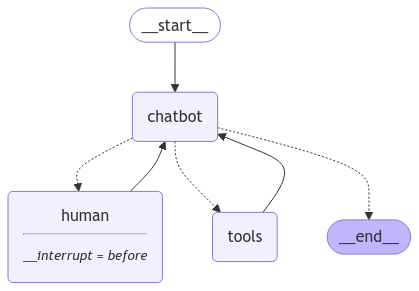

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass